In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import os
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
import numpy as np
import logging
import pickle
from torch.optim import lr_scheduler
from tqdm import tqdm
import torch.optim as optim
from glob import glob

### Defining the model and parameter

In [2]:
class DroughtDataset(Dataset):
    def __init__(self, inputs, targets=None):
        """
        Args:
            inputs (numpy.ndarray): Array of input data.
            targets (numpy.ndarray, optional): Array of target data. Defaults to None.
        """
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Return a tuple of input and target if targets are provided
        if self.targets is not None:
            return torch.tensor(self.inputs[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)
        # Otherwise return only the input
        return torch.tensor(self.inputs[idx], dtype=torch.float32)

In [3]:
def make_layers(block):
    layers = []
    for layer_name, v in block.items():
        if 'pool' in layer_name:
            layer = nn.MaxPool2d(kernel_size=v[0], stride=v[1], padding=v[2])
            layers.append((layer_name, layer))
        elif 'deconv' in layer_name:
            transposeConv2d = nn.ConvTranspose2d(in_channels=v[0],
                                                 out_channels=v[1],
                                                 kernel_size=v[2],
                                                 stride=v[3],
                                                 padding=v[4])
            layers.append((layer_name, transposeConv2d))
            if 'relu' in layer_name:
                layers.append(('relu_' + layer_name, nn.ReLU(inplace=True)))
            elif 'leaky' in layer_name:
                layers.append(('leaky_' + layer_name,
                               nn.LeakyReLU(negative_slope=0.2, inplace=True)))
        elif 'conv' in layer_name:
            conv2d = nn.Conv2d(in_channels=v[0],
                               out_channels=v[1],
                               kernel_size=v[2],
                               stride=v[3],
                               padding=v[4])
            layers.append((layer_name, conv2d))
            if 'relu' in layer_name:
                layers.append(('relu_' + layer_name, nn.ReLU(inplace=True)))
            elif 'leaky' in layer_name:
                layers.append(('leaky_' + layer_name,
                               nn.LeakyReLU(negative_slope=0.2, inplace=True)))
        else:
            raise NotImplementedError
    return nn.Sequential(OrderedDict(layers))


class CLSTM_cell(nn.Module):
    """ConvLSTMCell
    """
    def __init__(self, shape, input_channels, filter_size, num_features):
        super(CLSTM_cell, self).__init__()

        self.shape = shape  # H, W
        self.input_channels = input_channels
        self.filter_size = filter_size
        self.num_features = num_features
        # in this way the output has the same size
        self.padding = (filter_size - 1) // 2
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_channels + self.num_features,
                      4 * self.num_features, self.filter_size, 1,
                      self.padding),
            nn.GroupNorm(4 * self.num_features // 32, 4 * self.num_features))

    def forward(self, inputs=None, hidden_state=None, seq_len=3):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #  seq_len=10 for moving_mnist
        if hidden_state is None:
            hx = torch.zeros(inputs.size(1), self.num_features, self.shape[0],
                             self.shape[1]).to(device)
            cx = torch.zeros(inputs.size(1), self.num_features, self.shape[0],
                             self.shape[1]).to(device)
        else:
            hx, cx = hidden_state
        output_inner = []
        for index in range(seq_len):
            if inputs is None:
                x = torch.zeros(hx.size(0), self.input_channels, self.shape[0],
                                self.shape[1]).to(device)
            else:
                x = inputs[index, ...]

            combined = torch.cat((x, hx), 1)
            gates = self.conv(combined)  # gates: S, num_features*4, H, W
            # it should return 4 tensors: i,f,g,o
            ingate, forgetgate, cellgate, outgate = torch.split(
                gates, self.num_features, dim=1)
            ingate = torch.sigmoid(ingate)
            forgetgate = torch.sigmoid(forgetgate)
            cellgate = torch.tanh(cellgate)
            outgate = torch.sigmoid(outgate)

            cy = (forgetgate * cx) + (ingate * cellgate)
            hy = outgate * torch.tanh(cy)
            output_inner.append(hy)
            hx = hy
            cx = cy
        return torch.stack(output_inner), (hy, cy)
class Encoder(nn.Module):
    def __init__(self, subnets, rnns):
        super().__init__()
        assert len(subnets) == len(rnns)
        self.blocks = len(subnets)

        for index, (params, rnn) in enumerate(zip(subnets, rnns), 1):
            # index sign from 1
            setattr(self, 'stage' + str(index), make_layers(params))
            setattr(self, 'rnn' + str(index), rnn)

    def forward_by_stage(self, inputs, subnet, rnn):
        seq_number, batch_size, input_channel, height, width = inputs.size()
        inputs = torch.reshape(inputs, (-1, input_channel, height, width))
        inputs = subnet(inputs)
        inputs = torch.reshape(inputs, (seq_number, batch_size, inputs.size(1),
                                        inputs.size(2), inputs.size(3)))
        outputs_stage, state_stage = rnn(inputs,None)
        return outputs_stage, state_stage

    def forward(self, inputs):
        inputs = inputs.transpose(0, 1)  # to S,B,1,64,64
        hidden_states = []
        logging.debug(inputs.size())
        for i in range(1, self.blocks + 1):
            inputs, state_stage = self.forward_by_stage(
                inputs, getattr(self, 'stage' + str(i)),
                getattr(self, 'rnn' + str(i)))
            hidden_states.append(state_stage)
        return tuple(hidden_states)
class Decoder(nn.Module):
    def __init__(self, subnets, rnns):
        super().__init__()
        assert len(subnets) == len(rnns)

        self.blocks = len(subnets)

        for index, (params, rnn) in enumerate(zip(subnets, rnns)):
            setattr(self, 'rnn' + str(self.blocks - index), rnn)
            setattr(self, 'stage' + str(self.blocks - index),
                    make_layers(params))

    def forward_by_stage(self, inputs, state, subnet, rnn):
        
        inputs, state_stage = rnn(inputs, state, seq_len=1)
        seq_number, batch_size, input_channel, height, width = inputs.size()
        inputs = torch.reshape(inputs, (-1, input_channel, height, width))
        inputs = subnet(inputs)
        inputs = torch.reshape(inputs, (seq_number, batch_size, inputs.size(1),
                                        inputs.size(2), inputs.size(3)))
        return inputs

        # input: 5D S*B*C*H*W

    def forward(self, hidden_states):
        inputs = self.forward_by_stage(None, hidden_states[-1],
                                       getattr(self, 'stage3'),
                                       getattr(self, 'rnn3'))
        for i in list(range(1, self.blocks))[::-1]:
            inputs = self.forward_by_stage(inputs, hidden_states[i - 1],
                                           getattr(self, 'stage' + str(i)),
                                           getattr(self, 'rnn' + str(i)))
        inputs = inputs.transpose(0, 1)  # to B,S,1,64,64
        return inputs
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model, epoch, save_path):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch, save_path)
        elif score < self.best_score:
            self.counter += 1
            print(
                f'EarlyStopping counter: {self.counter} out of {self.patience}'
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch, save_path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, epoch, save_path):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...'
            )
        ls=glob(save_path+'*')
        if len(ls)>0:
            for i in ls:
                os.remove(i)
        torch.save(
            model, save_path + "/" +
            "checkpoint_{}_{:.6f}.pth.tar".format(epoch, val_loss))
        self.val_loss_min = val_loss

In [4]:
import torch.nn.functional as F
class activation():

    def __init__(self, act_type, negative_slope=0.2, inplace=True):
        super().__init__()
        self._act_type = act_type
        self.negative_slope = negative_slope
        self.inplace = inplace

    def __call__(self, input):
        if self._act_type == 'leaky':
            return F.leaky_relu(input, negative_slope=self.negative_slope, inplace=self.inplace)
        elif self._act_type == 'relu':
            return F.relu(input, inplace=self.inplace)
        elif self._act_type == 'sigmoid':
            return torch.sigmoid(input)
        else:
            raise NotImplementedError


class ED(nn.Module):
    
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input):
        state = self.encoder(input)
        output = self.decoder(state)
        return output

In [5]:
encoder_params = [
    [
        OrderedDict({'conv1_leaky_1': [1, 16, 3, 1, 1]}),
        OrderedDict({'conv2_leaky_1': [64, 64, 3, 2, 1]}),
        OrderedDict({'conv3_leaky_1': [96, 96, 3, 2, 1]}),
    ],

    [
        CLSTM_cell(shape=(64,64), input_channels=16, filter_size=5, num_features=64),
        CLSTM_cell(shape=(32,32), input_channels=64, filter_size=5, num_features=96),
        CLSTM_cell(shape=(16,16), input_channels=96, filter_size=5, num_features=96)
    ]
]
decoder_params = [
    [
        OrderedDict({'deconv1_leaky_1': [96, 96, 4, 2, 1]}),
        OrderedDict({'deconv2_leaky_1': [96, 96, 4, 2, 1]}),
        OrderedDict({
            'conv3_leaky_1': [64, 16, 3, 1, 1],
            'conv4_leaky_1': [16, 1, 1, 1, 0]
        }),
    ],

    [
        CLSTM_cell(shape=(16,16), input_channels=96, filter_size=5, num_features=96),
        CLSTM_cell(shape=(32,32), input_channels=96, filter_size=5, num_features=96),
        CLSTM_cell(shape=(64,64), input_channels=96, filter_size=5, num_features=64),
    ]
]

### Preparing the data 

In [6]:
with open('/kaggle/input/drought-convlstm/array_forconvlstm.pickle','rb') as file:
    array_=pickle.load(file)
    
inputs=array_['input']
sh=inputs.shape
inputs=inputs.reshape(sh[0],sh[1],1,sh[2],sh[3])
outputs=array_['output']
sh=outputs.shape
outputs=outputs.reshape(sh[0],1,1,sh[1],sh[2])

In [7]:
outputs.shape

(141, 1, 1, 64, 64)

In [8]:
from sklearn.model_selection import train_test_split
train_index=np.arange(0,int(sh[0]*0.8)+1)
test_index=np.arange(int(sh[0]*0.8)+1,sh[0])
train_sample, valid_sample = train_test_split(train_index, test_size=0.2, random_state=42)
print('Training start from 0 to ',int(sh[0]*0.8))
print('Test start from ',int(sh[0]*0.8)+1)

print("Sampled array:", valid_sample)


Training start from 0 to  112
Test start from  113
Sampled array: [ 80   4  40  69  10  45  70  66  47  11  98  36  83 111  18   0  72  26
  81  53 104  91  12]


In [9]:
# Create dataset
train_dataset = DroughtDataset(inputs[train_sample,:,:], outputs[train_sample,:,:])
valid_dataset = DroughtDataset(inputs[valid_sample,:,:], outputs[valid_sample,:,:])
test_dataset = DroughtDataset(inputs[test_index,:,:],outputs[test_index,:,:])

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)


### Model Building

In [10]:
def train(epochs, learning_rate):
    '''
    main function to run the training
    '''
    encoder = Encoder(encoder_params[0], encoder_params[1])#.cuda()
    decoder = Decoder(decoder_params[0], decoder_params[1])#.cuda()
    net = ED(encoder, decoder)
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=10, verbose=True)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #if torch.cuda.device_count() > 1:
    #    net = nn.DataParallel(net)
    net.to(device)
    save_dir = './save_model/'
    if os.path.exists(os.path.join(save_dir,'checkpoint.pth.tar')):
        # load existing model
        print('==> loading existing model')
        model_info = torch.load(os.path.join(save_dir, 'checkpoin.pth.tar'))
        net.load_state_dict(model_info['state_dict'])
        optimizer = torch.optim.Adam(net.parameters())
        optimizer.load_state_dict(model_info['optimizer'])
        cur_epoch = model_info['epoch'] + 1
    else:
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        else:
            ls_file=glob('./save_model/*')
            for i in ls_file:
                os.remove(i)
        cur_epoch = 0
    
    lossfunction = nn.MSELoss()#.cuda()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    pla_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      factor=0.5,
                                                      patience=3,
                                                      verbose=True)

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    # mini_val_loss = np.inf
    for epoch in range(cur_epoch, epochs):
        ###################
        # train the model #
        ###################
        t = tqdm(train_dataloader, leave=False, total=len(train_dataloader))
        for i,(inputVar,targetVar)  in enumerate(t):
            inputs = inputVar.to(device)  # B,S,C,H,W
            label = targetVar.to(device)  # B,S,C,H,W
            optimizer.zero_grad()
            net.train()
            pred = net(inputs)  # B,S,C,H,W
            loss = lossfunction(pred, label)
            loss_aver = loss.item() / 10
            train_losses.append(loss_aver)
            loss.backward()
            torch.nn.utils.clip_grad_value_(net.parameters(), clip_value=10.0)
            optimizer.step()
            t.set_postfix({
                'trainloss': '{:.6f}'.format(loss_aver),
                'epoch': '{:02d}'.format(epoch)
            })
        #tb.add_scalar('TrainLoss', loss_aver, epoch)
        ######################
        # validate the model #
        ######################
        with torch.no_grad():
            net.eval()
            t = tqdm(valid_dataloader, leave=False, total=len(valid_dataloader))
            for i, (inputVar,targetVar) in enumerate(t):
                inputs = inputVar.to(device)
                label = targetVar.to(device)
                pred = net(inputs)
                loss = lossfunction(pred, label)
                loss_aver = loss.item() / 10
                # record validation loss
                valid_losses.append(loss_aver)
                #print ("validloss: {:.6f},  epoch : {:02d}".format(loss_aver,epoch),end = '\r', flush=True)
                t.set_postfix({
                    'validloss': '{:.6f}'.format(loss_aver),
                    'epoch': '{:02d}'.format(epoch)
                })

        torch.cuda.empty_cache()
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.6f} ' +
                     f'valid_loss: {valid_loss:.6f}')

        print(print_msg)
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        pla_lr_scheduler.step(valid_loss)  # lr_scheduler
        model_dict = {
            'epoch': epoch,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        early_stopping(valid_loss.item(), model_dict, epoch,save_dir)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    with open("avg_train_losses.txt", 'wt') as f:
        for i in avg_train_losses:
            print(i, file=f)

    with open("avg_valid_losses.txt", 'wt') as f:
        for i in avg_valid_losses:
            print(i, file=f)

In [11]:
train(1000,0.01)

[   0/1000] train_loss: 0.023621 valid_loss: 0.011045
Validation loss decreased (inf --> 0.011045).  Saving model ...


[   1/1000] train_loss: 0.009555 valid_loss: 0.008112
Validation loss decreased (0.011045 --> 0.008112).  Saving model ...


[   2/1000] train_loss: 0.007448 valid_loss: 0.006677
Validation loss decreased (0.008112 --> 0.006677).  Saving model ...


[   3/1000] train_loss: 0.006369 valid_loss: 0.005858
Validation loss decreased (0.006677 --> 0.005858).  Saving model ...


[   4/1000] train_loss: 0.005600 valid_loss: 0.005178
Validation loss decreased (0.005858 --> 0.005178).  Saving model ...


[   5/1000] train_loss: 0.005272 valid_loss: 0.005092
Validation loss decreased (0.005178 --> 0.005092).  Saving model ...


[   6/1000] train_loss: 0.004747 valid_loss: 0.004650
Validation loss decreased (0.005092 --> 0.004650).  Saving model ...


[   7/1000] train_loss: 0.004312 valid_loss: 0.004232
Validation loss decreased (0.004650 --> 0.004232).  Saving model ...


[   8/1000] train_loss: 0.004131 valid_loss: 0.004260
EarlyStopping counter: 1 out of 10


[   9/1000] train_loss: 0.003882 valid_loss: 0.003941
Validation loss decreased (0.004232 --> 0.003941).  Saving model ...


[  10/1000] train_loss: 0.003770 valid_loss: 0.003508
Validation loss decreased (0.003941 --> 0.003508).  Saving model ...


[  11/1000] train_loss: 0.003618 valid_loss: 0.003715
EarlyStopping counter: 1 out of 10


[  12/1000] train_loss: 0.003452 valid_loss: 0.003269
Validation loss decreased (0.003508 --> 0.003269).  Saving model ...


[  13/1000] train_loss: 0.003166 valid_loss: 0.003157
Validation loss decreased (0.003269 --> 0.003157).  Saving model ...


[  14/1000] train_loss: 0.003045 valid_loss: 0.003027
Validation loss decreased (0.003157 --> 0.003027).  Saving model ...


[  15/1000] train_loss: 0.003007 valid_loss: 0.003329
EarlyStopping counter: 1 out of 10


[  16/1000] train_loss: 0.002959 valid_loss: 0.003740
EarlyStopping counter: 2 out of 10


[  17/1000] train_loss: 0.003006 valid_loss: 0.002858
Validation loss decreased (0.003027 --> 0.002858).  Saving model ...


[  18/1000] train_loss: 0.002753 valid_loss: 0.003175
EarlyStopping counter: 1 out of 10


[  19/1000] train_loss: 0.002784 valid_loss: 0.002682
Validation loss decreased (0.002858 --> 0.002682).  Saving model ...


[  20/1000] train_loss: 0.002826 valid_loss: 0.003204
EarlyStopping counter: 1 out of 10


[  21/1000] train_loss: 0.002786 valid_loss: 0.002934
EarlyStopping counter: 2 out of 10


[  22/1000] train_loss: 0.002891 valid_loss: 0.002834
EarlyStopping counter: 3 out of 10


[  23/1000] train_loss: 0.002769 valid_loss: 0.002731
Epoch 00024: reducing learning rate of group 0 to 5.0000e-03.
EarlyStopping counter: 4 out of 10


[  24/1000] train_loss: 0.002537 valid_loss: 0.002979
EarlyStopping counter: 5 out of 10


[  25/1000] train_loss: 0.002503 valid_loss: 0.002568
Validation loss decreased (0.002682 --> 0.002568).  Saving model ...


[  26/1000] train_loss: 0.002488 valid_loss: 0.002443
Validation loss decreased (0.002568 --> 0.002443).  Saving model ...


[  27/1000] train_loss: 0.002516 valid_loss: 0.002636
EarlyStopping counter: 1 out of 10


[  28/1000] train_loss: 0.002493 valid_loss: 0.002433
Validation loss decreased (0.002443 --> 0.002433).  Saving model ...


[  29/1000] train_loss: 0.002402 valid_loss: 0.002546
EarlyStopping counter: 1 out of 10


[  30/1000] train_loss: 0.002383 valid_loss: 0.002365
Validation loss decreased (0.002433 --> 0.002365).  Saving model ...


[  31/1000] train_loss: 0.002374 valid_loss: 0.002359
Validation loss decreased (0.002365 --> 0.002359).  Saving model ...


[  32/1000] train_loss: 0.002366 valid_loss: 0.002660
EarlyStopping counter: 1 out of 10


[  33/1000] train_loss: 0.002333 valid_loss: 0.002506
EarlyStopping counter: 2 out of 10


[  34/1000] train_loss: 0.002311 valid_loss: 0.002386
EarlyStopping counter: 3 out of 10


[  35/1000] train_loss: 0.002302 valid_loss: 0.002306
Validation loss decreased (0.002359 --> 0.002306).  Saving model ...


[  36/1000] train_loss: 0.002286 valid_loss: 0.002370
EarlyStopping counter: 1 out of 10


[  37/1000] train_loss: 0.002315 valid_loss: 0.002384
EarlyStopping counter: 2 out of 10


[  38/1000] train_loss: 0.002333 valid_loss: 0.002454
EarlyStopping counter: 3 out of 10


[  39/1000] train_loss: 0.002360 valid_loss: 0.002394
Epoch 00040: reducing learning rate of group 0 to 2.5000e-03.
EarlyStopping counter: 4 out of 10


[  40/1000] train_loss: 0.002251 valid_loss: 0.002737
EarlyStopping counter: 5 out of 10


[  41/1000] train_loss: 0.002288 valid_loss: 0.002298
Validation loss decreased (0.002306 --> 0.002298).  Saving model ...


[  42/1000] train_loss: 0.002258 valid_loss: 0.002317
EarlyStopping counter: 1 out of 10


[  43/1000] train_loss: 0.002221 valid_loss: 0.002273
Validation loss decreased (0.002298 --> 0.002273).  Saving model ...


[  44/1000] train_loss: 0.002236 valid_loss: 0.002361
EarlyStopping counter: 1 out of 10


[  45/1000] train_loss: 0.002213 valid_loss: 0.002687
EarlyStopping counter: 2 out of 10


[  46/1000] train_loss: 0.002224 valid_loss: 0.002323
EarlyStopping counter: 3 out of 10


[  47/1000] train_loss: 0.002225 valid_loss: 0.002319
Epoch 00048: reducing learning rate of group 0 to 1.2500e-03.
EarlyStopping counter: 4 out of 10


[  48/1000] train_loss: 0.002192 valid_loss: 0.002205
Validation loss decreased (0.002273 --> 0.002205).  Saving model ...


[  49/1000] train_loss: 0.002181 valid_loss: 0.002457
EarlyStopping counter: 1 out of 10


[  50/1000] train_loss: 0.002173 valid_loss: 0.002183
Validation loss decreased (0.002205 --> 0.002183).  Saving model ...


[  51/1000] train_loss: 0.002164 valid_loss: 0.002540
EarlyStopping counter: 1 out of 10


[  52/1000] train_loss: 0.002165 valid_loss: 0.002276
EarlyStopping counter: 2 out of 10


[  53/1000] train_loss: 0.002187 valid_loss: 0.002224
EarlyStopping counter: 3 out of 10


[  54/1000] train_loss: 0.002147 valid_loss: 0.002213
Epoch 00055: reducing learning rate of group 0 to 6.2500e-04.
EarlyStopping counter: 4 out of 10


[  55/1000] train_loss: 0.002149 valid_loss: 0.002212
EarlyStopping counter: 5 out of 10


[  56/1000] train_loss: 0.002138 valid_loss: 0.002251
EarlyStopping counter: 6 out of 10


[  57/1000] train_loss: 0.002136 valid_loss: 0.002259
EarlyStopping counter: 7 out of 10


[  58/1000] train_loss: 0.002132 valid_loss: 0.002214
Epoch 00059: reducing learning rate of group 0 to 3.1250e-04.
EarlyStopping counter: 8 out of 10


[  59/1000] train_loss: 0.002130 valid_loss: 0.002318
EarlyStopping counter: 9 out of 10


[  60/1000] train_loss: 0.002133 valid_loss: 0.002307
EarlyStopping counter: 10 out of 10
Early stopping


In [12]:
valid_los= open('/kaggle/working/avg_valid_losses.txt','r')
content_valid = valid_los.readlines()
valid_los.close()
train_los= open('/kaggle/working/avg_train_losses.txt','r')
content_train = train_los.readlines()
train_los.close()
content_train=[float(i.replace('\n','')) for i in content_train]
content_valid=[float(i.replace('\n','')) for i in content_valid]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

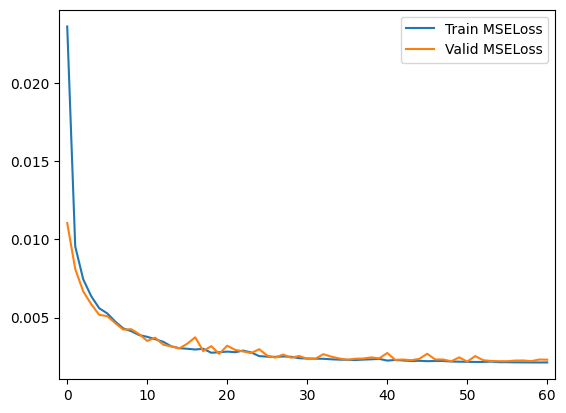

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a list of x-values
x = np.arange(len(content_train))

# Create the line plot
sns.lineplot(x=x, y=content_train,label='Train MSELoss')
sns.lineplot(x=x, y=content_valid,label='Valid MSELoss')
plt.xlim(0-1,len(content_train))
plt.show()

### Prediction and Testing

In [14]:
encoder = Encoder(encoder_params[0], encoder_params[1])#.cuda()
decoder = Decoder(decoder_params[0], decoder_params[1])#.cuda()
net = ED(encoder, decoder)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
saved_model=glob('/kaggle/working/save_model/*')
model_info = torch.load(saved_model[0])
net.load_state_dict(model_info['state_dict'])
net.eval()
dict_predict={}
lossfunction = nn.MSELoss()
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        inputs, targets = batch
        pred=net(inputs.to(device))
        loss = lossfunction(pred, targets.to(device)).item()
        dict_predict[i]={'input':inputs,
                        'target':targets,
                        'prediction':pred,
                        'loss':loss}

In [15]:
import pickle
with open('prediction_testing.pkl','wb') as file:
    pickle.dump(dict_predict,file)
loss_test=[dict_predict[i]['loss'] for i in dict_predict.keys()]
print('Average MSE_loss=',np.mean(loss_test))

Average MSE_loss= 0.0296185227177505


### Predict 2022 until 2023

In [16]:
input_2022=array_['input']
sh=input_2022.shape
input_2022=array_['input'].reshape(sh[0],sh[1],1,sh[2],sh[3])
input_2022_2023=np.zeros((26,1,1,sh[2],sh[3]))
output_2022_2023=np.zeros((24,1,1,sh[2],sh[3]))
input_2022_2023[:14,0,:,:,:]=input_2022[-14:,0,:,:,:]

In [17]:
input_2022_2023[0:3,0,:,:,:].reshape((1,3,1,sh[2],sh[3])).shape

(1, 3, 1, 64, 64)

In [18]:
for i in range(0,24):
    dt_input=input_2022_2023[i:i+3,0,:,:,:].reshape((1,3,1,sh[2],sh[3]))
    dt_input=torch.from_numpy(dt_input).to(device)
    dt_input=dt_input.float()
    with torch.no_grad():
        pred=net(dt_input)
        pred=pred.cpu().numpy()
        output_2022_2023[i,:,:,:,:]=pred
        if i>11:
            input_2022_2023[i+2,0,:,:,:]=pred

In [19]:
with open('output_2022_2023.pkl','wb') as file:
    pickle.dump(output_2022_2023.reshape(24,64,64),file)